In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

## GDP

https://fred.stlouisfed.org/series/GDP

In [2]:
df1 = pd.read_csv('Econometric/GDP.csv')
df1.head()

,DATE,GDP
0,1947-01-01,243.164
1,1947-04-01,245.968
2,1947-07-01,249.585
3,1947-10-01,259.745
4,1948-01-01,265.742


### Convert quarterly data to monthly data

In [3]:
# convert to period
df1['DATE'] = pd.to_datetime(df1['DATE']).dt.to_period('M')

# set Date as index and resample
df1 = df1.set_index('DATE').resample('M').interpolate()
df1.index = df1.index.to_timestamp()

df1.head()

,GDP
DATE,
1947-01-01,243.164000
1947-02-01,244.098667
1947-03-01,245.033333
1947-04-01,245.968000
1947-05-01,247.173667


##  Total Construction Spending: Total Construction in the United States 

https://fred.stlouisfed.org/series/TTLCONS

In [4]:
df2 = pd.read_csv('Econometric/TTLCONS.csv', index_col='DATE',parse_dates=True)
df2.index.freq = 'MS'
df2['TTLCONS'] = df2['TTLCONS']/1000
df2.head()

,TTLCONS
DATE,
1993-01-01,458.080
1993-02-01,462.967
1993-03-01,458.399
1993-04-01,469.425
1993-05-01,468.998


## Domestic Auto Production
https://fred.stlouisfed.org/series/DAUPSA

In [5]:
df3 =  pd.read_csv('Econometric/DAUPSA.csv', index_col='DATE',parse_dates=True)
df3.head()

,DAUPSA
DATE,
1993-01-01,512.9
1993-02-01,503.8
1993-03-01,498.1
1993-04-01,510.2
1993-05-01,512.8


##  Industrial Production: Total Index 
https://fred.stlouisfed.org/series/INDPRO

In [6]:
df4 =  pd.read_csv('Econometric/INDPRO.csv', index_col='DATE',parse_dates=True)
df4.head()

,INDPRO
DATE,
1919-01-01,4.8665
1919-02-01,4.6514
1919-03-01,4.5170
1919-04-01,4.5976
1919-05-01,4.6245


https://fred.stlouisfed.org/series/WPU107301

In [7]:
df5 = pd.read_csv('Sheet_metal_mng.csv', index_col='Date',parse_dates=True)
df5 = df5.rename_axis('DATE')
df5.head()

,Price
DATE,
1982-12-01,100.0
1983-01-01,99.4
1983-02-01,99.7
1983-03-01,100.1
1983-04-01,100.3


In [8]:
# Concatenate the DataFrames along rows using pd.concat()
data_frames = [df1, df2, df3, df4, df5]
df = pd.concat(data_frames, axis=1, join='inner')  # 'inner' join retains only mutual dates
df.head()

,GDP,TTLCONS,DAUPSA,INDPRO,Price
DATE,,,,,
1993-01-01,6729.459000,458.080,512.9,64.6256,126.9
1993-02-01,6755.952333,462.967,503.8,64.9290,126.4
1993-03-01,6782.445667,458.399,498.1,64.8720,127.1
1993-04-01,6808.939000,469.425,510.2,65.0611,127.3
1993-05-01,6833.325333,468.998,512.8,64.8104,126.5


In [9]:

# Define the Min-Max scaling function
def min_max_scaling(column):
    min_val = column.min()
    max_val = column.max()
    return (column - min_val) / (max_val - min_val)

# Apply Min-Max scaling to each column
df = df.apply(min_max_scaling)
df.head()

,GDP,TTLCONS,DAUPSA,INDPRO,Price
DATE,,,,,
1993-01-01,0.000000,0.000000,0.870869,0.000000,0.002889
1993-02-01,0.001318,0.003371,0.855366,0.007682,0.000000
1993-03-01,0.002635,0.000220,0.845656,0.006239,0.004045
1993-04-01,0.003953,0.007825,0.866269,0.011027,0.005200
1993-05-01,0.005166,0.007531,0.870698,0.004679,0.000578


                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     1609.
Date:                Fri, 01 Sep 2023   Prob (F-statistic):          9.97e-228
Time:                        16:51:14   Log-Likelihood:                 556.41
No. Observations:                 364   AIC:                            -1103.
Df Residuals:                     359   BIC:                            -1083.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0305      0.025      1.237      0.2

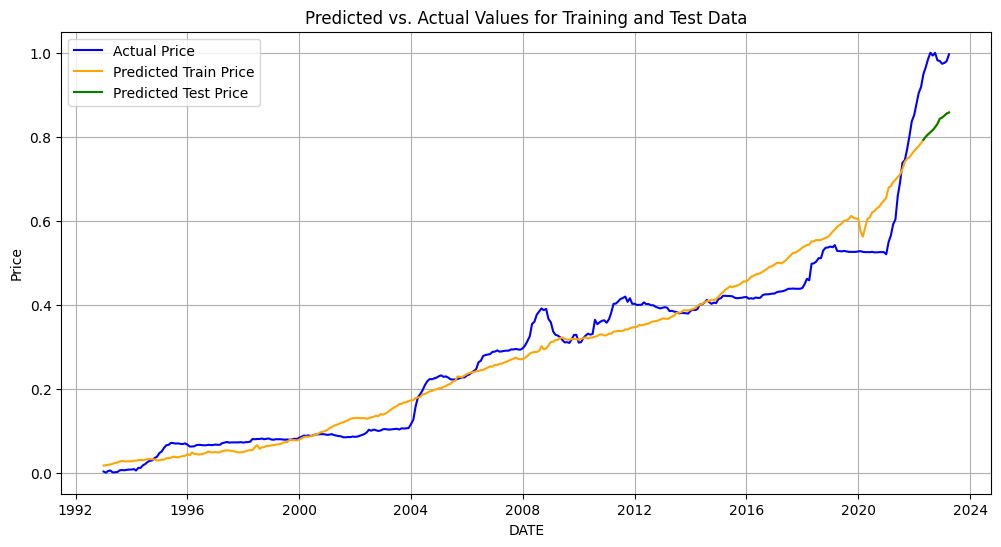

In [10]:
# Define the dependent variable (Price) and independent variables
y = df['Price']
X = df[['GDP', 'TTLCONS', 'DAUPSA', 'INDPRO']]

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X)
results = model.fit()

# Print the model summary
print(results.summary())

# Predict the values for the training data
predicted_train = results.predict(X)

# Split data into training and test sets
train = df.iloc[:-12]  # All except the last 12 rows
test = df.iloc[-12:]   # Last 12 rows for testing

# Predict the values for the test data
X_test = sm.add_constant(test[['GDP', 'TTLCONS', 'DAUPSA', 'INDPRO']])
predicted_test = results.predict(X_test)

# Calculate Econometrics MSE and RMSE
Eco_mse = mean_squared_error(test['Price'], predicted_test)
Eco_rmse = np.sqrt(Eco_mse)
print("\n\n")
print("Econometrics Forecast Mean Squared Error:", Eco_mse)
print("Econometrics Forecast Root Mean Squared Error:", Eco_rmse)
print(f'Price Mean: {df.Price.mean():11.10}')
print(f'Prediction Price Mean: {predicted_test.mean():11.10}')


# Plotting the predicted values and actual values for both training and test data
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Price'], color='blue', label='Actual Price')
plt.plot(df.index, predicted_train, color='orange', label='Predicted Train Price')
plt.plot(test.index, predicted_test, color='green', label='Predicted Test Price')
plt.xlabel('DATE')
plt.ylabel('Price')
plt.title('Predicted vs. Actual Values for Training and Test Data')
plt.legend()
plt.grid()
plt.show()




Econometrics Forecast Mean Squared Error: 0.054355352216298634
Econometrics Forecast Root Mean Squared Error: 0.23314234325042424
Price Mean: 0.2999064935
Prediction Price Mean: 0.7493018166


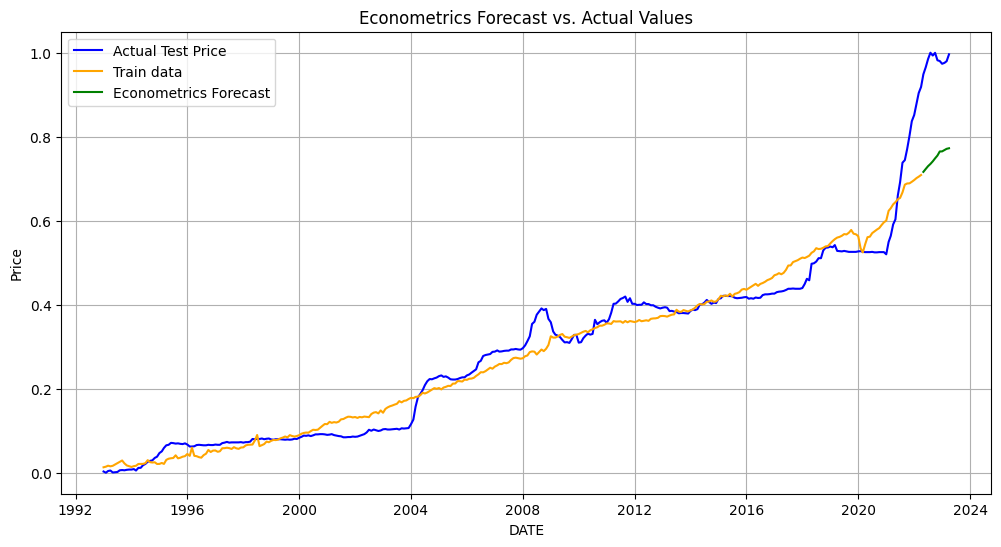

In [11]:
from sklearn.linear_model import LinearRegression

train = df.iloc[:-12]  # All except the last 12 rows
test = df.iloc[-12:]   # Last 12 rows for testing

# Define the dependent variable (MetalSheetDemand) and independent variables
y_train = train['Price']
X_train = train[['GDP', 'TTLCONS', 'DAUPSA', 'INDPRO']]
X_test = test[['GDP', 'TTLCONS', 'DAUPSA', 'INDPRO']]
y_test = test['Price']

model = LinearRegression()
model.fit(X_train, y_train)

# Predict the model
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
# Calculate ARIMA MSE and RMSE
Eco_mse = mean_squared_error(y_test, y_pred)
Eco_rmse = np.sqrt(Eco_mse)

print("\n\n")
print("Econometrics Forecast Mean Squared Error:", Eco_mse)
print("Econometrics Forecast Root Mean Squared Error:", Eco_rmse)
print(f'Price Mean: {df.Price.mean():11.10}')
print(f'Prediction Price Mean: {y_pred.mean():11.10}')

# Plotting the ARIMA forecast and actual test values
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Price'], color='blue', label='Actual Test Price')  # Plotting actual values
plt.plot(y_train.index, y_pred_train, color='orange', label='Train data')  # Plotting Econometrics forecast
plt.plot(y_test.index, y_pred, color='green', label='Econometrics Forecast')  # Plotting Econometrics forecast
plt.xlabel('DATE')
plt.ylabel('Price')
plt.title('Econometrics Forecast vs. Actual Values')
plt.legend()
plt.grid()
plt.show()
